# CCA vs FBCCA

## Setup

In [1]:
%matplotlib inline

In [2]:
%%javascript
// Disable scroll bar
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import scipy.signal
import pandas as pd
import xarray as xr
import numpy as np
from pprint import pprint
from functools import reduce
import re
from matplotlib import pyplot as plt
from IPython.display import display, Markdown

## Constants

In [4]:
PI = np.pi

### Experiment Constant

In [5]:
sampling_frequency = 250
candidate_frequency = [7, 7.5, 8, 9, 10, 11, 12]
reference_signal_phase = 0
correct_frequency = 7.5

### FBCCA Constant

In [6]:
# Band Pass Filter Constant
filter_order = 2
subband_width = 8
# add pad frequency to both and high
padding_frequency = 0
num_subband = 10
# from paper
subband_weight_a = 1.25
subband_weight_b = 0.25

## Define Modules

In [7]:
# Generate Reference Frequency
sin = lambda f, h, t, p: np.sin(2*PI*f*h*t + p)
cos = lambda f, h, t, p: np.cos(2*PI*f*h*t + p)
ref_wave = lambda f, h, t, p: [sin(f, h, t, p), cos(f, h, t, p)]

def generate_reference_signal_at_time(f, t, max_harmonic, phase):
    values = []
    for h in range(1, max_harmonic + 1):
        values += ref_wave(f, h, t, phase)
    return values

def generate_reference_signal(frequency, sampling_frequency, total_time, max_harmonic, phase):
    ref_signal = []
    num_time_step = total_time * sampling_frequency
    for step in range(num_time_step):
        time = step * 1/sampling_frequency
        ref_signal_at_t = generate_reference_signal_at_time(frequency, time, max_harmonic, phase)
        ref_signal.append(ref_signal_at_t)
    return ref_signal

In [8]:
# Band Filter Input Signal
def filter_signal(data, low_cutoff_frequency, high_cutoff_frequency):
    nyquist_frequency = sampling_frequency / 2 # half of sampling frequency
    low = low_cutoff_frequency / nyquist_frequency
    high = high_cutoff_frequency / nyquist_frequency
    b, a = scipy.signal.butter(filter_order, [low, high], btype='band', analog=False)
    filtered_signal = scipy.signal.filtfilt(b, a, data)
    return filtered_signal

In [9]:
# Solve for Maximum CCA from two multidimensional signal
def find_maximum_canonical_correlations(X, Y):
    if X.shape[0] == Y.shape[0]:
        N = X.shape[0]
    else:
        print('time frame is not equal')
        return None
    C_xx = 1/N * (X.T @ X)
    C_yy = 1/N * (Y.T @ Y)
    C_xy = 1/N * (X.T @ Y)
    C_yx = 1/N * (Y.T @ X)
    C_xx_inv = np.linalg.pinv(C_xx)
    C_yy_inv = np.linalg.pinv(C_yy)
    eig_values, eig_vectors = scipy.linalg.eig(C_yy_inv @ C_yx @ C_xx_inv @ C_xy)
    sqrt_eig_values = np.sqrt(eig_values)
    return max(sqrt_eig_values)

In [10]:
def generate_subband_cutoff(subband_type, start_frequency, subband_width, padding_frequency, num_subband):
    # M1
    if subband_type == 'M1':
        return [
            (start_frequency + subband_width * i - padding_frequency,
             start_frequency + subband_width * (i + 1) + padding_frequency)
            for i in range(1,  num_subband + 1)
        ]
    if subband_type == 'M2':
        last_cutoff = start_frequency + subband_width * (num_subband + 1) + padding_frequency
        return [
            (start_frequency + subband_width * i - padding_frequency,
             min(start_frequency + 2 * subband_width * i + padding_frequency, last_cutoff))
            for i in range(1,  num_subband + 1)
        ]
    # M3
    if subband_type == 'M3':
        last_cutoff = start_frequency + subband_width * (num_subband + 1) + padding_frequency
        return [
            (start_frequency + subband_width * i - padding_frequency,
             last_cutoff)
            for i in range(1, num_subband + 1)
        ]

In [11]:
# Sub band signal weight for FBCCA
# optimal a, b from the paper
def subband_weight(n, a=1.25, b=0.25):
    return n ** (-a) + b

In [12]:
def get_subband_weight_vector(num_subband, a=1.25, b=0.25):
    return np.array([subband_weight(n+1, a, b) for n in range(num_subband)])

## Generate Reference Signal

Generate reference signal from candidate frequency upto 6th harmonic

In [13]:
ref_signal = {}
for frequency in candidate_frequency:
    signal = generate_reference_signal(
            frequency=frequency,
            sampling_frequency=250,
            total_time=2,
            max_harmonic=6,
            phase=reference_signal_phase
    )
    ref_signal[frequency] = pd.DataFrame(signal)

## Load Data

In [14]:
data = {}
data['resting'] = np.load('./data/resting_state.npy')
data['condition_2'] = np.load('./data/condition2.npy')
data['condition_3'] = np.load('./data/condition3.npy')
data['condition_4'] = np.load('./data/condition4.npy')

In [15]:
# 20 people
# 27 sliding window
# 500 data points, 250Hz for 2s
num_people = data['condition_2'].shape[0]
# num_people = 3
num_window = data['condition_2'].shape[1]
# num_people = 2
# num_window = 5

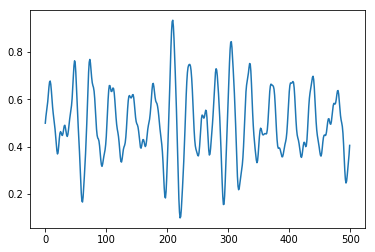

In [16]:
plt.plot(data['condition_2'][0][1])

## CCA

In [17]:
def classify_cca(input_data, ref_signal):
    input_signal = pd.DataFrame(input_data)
    max_cca = {}
    for ref_signal_key in ref_signal.keys():
        value = find_maximum_canonical_correlations(input_signal, ref_signal[ref_signal_key])
        if value.imag == 0.0:
            value = value.real
        else:
            value = None
        max_cca[ref_signal_key] = value
    return max_cca

In [18]:
result = {}
for people_index in range(num_people):
    result[f'person_{people_index}'] = []
    for window_index in range(num_window):
        result[f'person_{people_index}'].append(
            classify_cca(data['condition_2'][people_index][window_index], ref_signal)
        )
    pd.DataFrame(result[f'person_{people_index}'])

In [19]:
for people_index in range(num_people):
    display(Markdown(f'## Person #{people_index}'))
    columns = pd.DataFrame(result[f'person_{people_index}']).columns.values
    value = pd.DataFrame(result[f'person_{people_index}']).idxmax(axis=1)
    display(Markdown('Should be classify as **7.5Hz**'))
    display(Markdown(f"Correctly classify {np.sum(value == correct_frequency)} / {len(value)}"))
    display(Markdown(f"Accuracy {np.sum(value == correct_frequency) / len(value)}"))
    display(pd.DataFrame(result[f'person_{people_index}']))

## Person #0

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.053200,0.148506,0.077320,0.099569,0.058213,0.068755,0.053667
1,0.064474,0.190497,0.087203,0.021790,0.106436,0.087644,0.024320
2,0.077107,0.153921,0.027931,0.052577,0.125763,0.101051,0.010182
3,0.035762,0.099732,0.059571,0.048034,0.052414,0.096607,0.017305
4,0.039066,0.069751,0.012481,0.065444,0.041337,0.025367,0.028783
5,0.028576,0.113777,0.052729,0.024227,0.085255,0.057308,0.067877
6,0.059569,0.146190,0.032008,0.052612,0.099816,0.039065,0.012519
7,0.073252,0.128281,0.056504,0.085673,0.070045,0.023574,0.027209
8,0.031221,0.122933,0.034791,0.067364,0.035971,0.044140,0.010980
9,0.030166,0.172670,0.062002,0.012570,0.013565,0.054208,0.011713


## Person #1

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.087806,0.138454,0.071771,0.061960,0.030979,0.055502,0.038662
1,0.023431,0.267182,0.084561,0.052003,0.015773,0.051328,0.056415
2,0.048491,0.212059,0.135421,0.119980,0.027328,0.040277,0.026025
3,0.040474,0.146653,0.017422,0.081475,0.056121,0.045403,0.035605
4,0.058697,0.142806,0.019348,0.044417,0.033991,0.084796,0.049199
5,0.018229,0.131517,0.069656,0.076446,0.052886,0.085379,0.064556
6,0.035766,0.140814,0.033436,0.037630,0.060369,0.029122,0.011602
7,0.012379,0.195698,0.064043,0.048385,0.043567,0.095330,0.054266
8,0.047181,0.206056,0.072986,0.036057,0.035291,0.031989,0.062024
9,0.046702,0.124715,0.093875,0.030238,0.034411,0.077153,0.014513


## Person #2

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.042653,0.123099,0.057407,0.037593,0.101237,0.160025,0.081601
1,0.028023,0.140653,0.046032,0.046587,0.019785,0.059446,0.040414
2,0.039014,0.102696,0.045778,0.035043,0.105002,0.073565,0.049410
3,0.045770,0.079503,0.035668,0.039189,0.063729,0.075518,0.051027
4,0.041196,0.069974,0.013270,0.062700,0.093833,0.094344,0.029373
5,0.066760,0.089660,0.059116,0.043275,0.084517,0.072645,0.042309
6,0.037769,0.109243,0.019053,0.045347,0.009934,0.022331,0.040170
7,0.062353,0.061881,0.029292,0.010407,0.098758,0.053819,0.014989
8,0.044749,0.077198,0.058060,0.035425,0.087908,0.058581,0.061734
9,0.046290,0.136936,0.031605,0.060831,0.133580,0.023155,0.052630


## Person #3

Should be classify as **7.5Hz**

Correctly classify 26 / 27

Accuracy 0.9629629629629629

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.048540,0.202343,0.032138,0.088201,0.078763,0.057628,0.032529
1,0.038547,0.146048,0.014329,0.049485,0.034729,0.109599,0.010154
2,0.090691,0.081661,0.064290,0.089287,0.055740,0.102614,0.044401
3,0.023609,0.160412,0.079222,0.060280,0.019335,0.057313,0.049488
4,0.074281,0.213259,0.035773,0.026426,0.034219,0.037096,0.036857
5,0.056085,0.234687,0.146377,0.044148,0.031115,0.067728,0.013686
6,0.041306,0.241805,0.106550,0.054480,0.009258,0.026899,0.034165
7,0.069158,0.265075,0.072394,0.093772,0.020778,0.014127,0.045083
8,0.066822,0.253891,0.071503,0.050123,0.032642,0.031228,0.012222
9,0.028860,0.178680,0.029196,0.065935,0.064216,0.047208,0.028764


## Person #4

Should be classify as **7.5Hz**

Correctly classify 11 / 27

Accuracy 0.4074074074074074

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.042564,0.121207,0.030480,0.174714,0.068891,0.107196,0.057697
1,0.059327,0.088306,0.086071,0.128994,0.043341,0.014784,0.092707
2,0.052421,0.172606,0.026174,0.071526,0.025279,0.016616,0.093074
3,0.064036,0.127370,0.056560,0.024366,0.117490,0.036047,0.056893
4,0.082099,0.085691,0.061964,0.060968,0.135901,0.114526,0.077673
5,0.101542,0.074842,0.040980,0.079283,0.085055,0.090238,0.092723
6,0.031445,0.067605,0.040911,0.065661,0.019270,0.037017,0.054640
7,0.047620,0.102730,0.069234,0.052843,0.012343,0.062245,0.029151
8,0.039719,0.094687,0.038845,0.067383,0.012986,0.108025,0.033846
9,0.045912,0.043374,0.057467,0.084326,0.015987,0.113990,0.054573


## Person #5

Should be classify as **7.5Hz**

Correctly classify 19 / 27

Accuracy 0.7037037037037037

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.023562,0.051836,0.002666,0.024016,0.029777,0.019816,0.008560
1,0.022255,0.053418,0.020361,0.033378,0.023539,0.016676,0.011552
2,0.031474,0.024006,0.026587,0.023452,0.020105,0.020878,0.005730
3,0.015027,0.032273,0.037260,0.022365,0.007505,0.013913,0.013543
4,0.008442,0.041235,0.027520,0.021572,0.007801,0.006656,0.014529
5,0.040158,0.030373,0.031413,0.021071,0.046491,0.013558,0.004932
6,0.042440,0.057608,0.015682,0.011210,0.046107,0.007102,0.006390
7,0.023330,0.049404,0.016543,0.033953,0.031878,0.017468,0.015225
8,0.021173,0.041412,0.005903,0.033098,0.032926,0.017046,0.027070
9,0.026238,0.039686,0.026637,0.021067,0.057784,0.003533,0.018683


## Person #6

Should be classify as **7.5Hz**

Correctly classify 24 / 27

Accuracy 0.8888888888888888

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.023388,0.118384,0.070290,0.034749,0.028726,0.065908,0.063598
1,0.063993,0.141105,0.031068,0.053162,0.046115,0.093714,0.023405
2,0.037525,0.201303,0.045957,0.061471,0.016237,0.025171,0.009407
3,0.043900,0.183600,0.041012,0.064337,0.042336,0.008690,0.015943
4,0.098324,0.123181,0.044346,0.080852,0.053028,0.041663,0.073627
5,0.071906,0.099111,0.103732,0.065786,0.016608,0.016145,0.062437
6,0.017867,0.128514,0.042034,0.087543,0.061326,0.021265,0.037992
7,0.033581,0.148396,0.029508,0.022224,0.063516,0.021077,0.040882
8,0.021661,0.143747,0.030327,0.008528,0.047137,0.039441,0.062810
9,0.042757,0.107703,0.039449,0.052986,0.092796,0.080916,0.031430


## Person #7

Should be classify as **7.5Hz**

Correctly classify 9 / 27

Accuracy 0.3333333333333333

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.017344,0.055197,0.021243,0.032397,0.094675,0.053909,0.025815
1,0.012756,0.117714,0.095742,0.111858,0.022876,0.025228,0.010459
2,0.061539,0.127928,0.193619,0.077240,0.069821,0.051191,0.031432
3,0.088945,0.097270,0.141963,0.132435,0.054639,0.047184,0.015729
4,0.016284,0.066429,0.108001,0.063431,0.066002,0.035966,0.008239
5,0.123701,0.209336,0.078762,0.158213,0.054026,0.012928,0.013756
6,0.106901,0.257108,0.097399,0.164352,0.086043,0.026433,0.017124
7,0.018230,0.235751,0.022007,0.170140,0.058560,0.026232,0.023311
8,0.101700,0.185744,0.041388,0.103929,0.037028,0.046320,0.017524
9,0.032052,0.068936,0.140395,0.126308,0.073843,0.008148,0.027761


## Person #8

Should be classify as **7.5Hz**

Correctly classify 14 / 27

Accuracy 0.5185185185185185

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.113394,0.082927,0.049729,0.089101,0.094616,0.043701,0.057302
1,0.052403,0.118739,0.066209,0.074836,0.070549,0.045463,0.034128
2,0.075378,0.098926,0.051616,0.053913,0.065971,0.053209,0.036890
3,0.090602,0.140437,0.095096,0.102061,0.022528,0.052191,0.018682
4,0.022430,0.107838,0.072467,0.092811,0.079747,0.006160,0.027377
5,0.048276,0.103853,0.079165,0.095279,0.046942,0.015741,0.065202
6,0.035291,0.176998,0.043927,0.102575,0.054163,0.036527,0.009704
7,0.107566,0.125930,0.040247,0.054876,0.077299,0.064432,0.061866
8,0.110030,0.036449,0.050605,0.041568,0.053387,0.035772,0.045115
9,0.070183,0.087676,0.120651,0.016506,0.020169,0.030565,0.033907


## Person #9

Should be classify as **7.5Hz**

Correctly classify 23 / 27

Accuracy 0.8518518518518519

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.042830,0.180100,0.093531,0.049139,0.003892,0.034166,0.064063
1,0.027897,0.166645,0.018085,0.053118,0.047188,0.023664,0.040198
2,0.065756,0.178070,0.015042,0.060740,0.042420,0.020477,0.035643
3,0.045476,0.188542,0.021511,0.101090,0.051275,0.021174,0.011039
4,0.051926,0.165542,0.035729,0.052223,0.021750,0.027360,0.067808
5,0.059742,0.136863,0.067657,0.137375,0.082968,0.094413,0.047483
6,0.049074,0.091689,0.112842,0.092945,0.033502,0.095680,0.065625
7,0.072465,0.169568,0.042299,0.025341,0.068176,0.060531,0.042845
8,0.044673,0.172326,0.024055,0.063630,0.086685,0.043627,0.055755
9,0.049337,0.134633,0.069817,0.057178,0.173622,0.068253,0.105868


## Person #10

Should be classify as **7.5Hz**

Correctly classify 23 / 27

Accuracy 0.8518518518518519

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.033546,0.118303,0.086581,0.026578,0.063989,0.021791,0.028652
1,0.061740,0.110855,0.059092,0.007123,0.025080,0.030001,0.064015
2,0.022011,0.188026,0.045598,0.061600,0.011481,0.031529,0.077402
3,0.051113,0.143553,0.060429,0.019124,0.010644,0.040278,0.045301
4,0.035462,0.157636,0.086476,0.011315,0.012705,0.062498,0.069013
5,0.027954,0.227197,0.044367,0.046106,0.042622,0.007763,0.052939
6,0.074320,0.174964,0.073971,0.026864,0.037267,0.016839,0.028844
7,0.061399,0.101211,0.085419,0.009622,0.051851,0.075202,0.032921
8,0.030237,0.148454,0.072142,0.071743,0.080818,0.075499,0.031691
9,0.019377,0.182318,0.078056,0.029113,0.013266,0.022217,0.038743


## Person #11

Should be classify as **7.5Hz**

Correctly classify 14 / 27

Accuracy 0.5185185185185185

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.060647,0.035986,0.005647,0.027406,0.069470,0.013990,0.027095
1,0.046827,0.111657,0.031440,0.046939,0.074823,0.036720,0.023743
2,0.020875,0.107427,0.052293,0.072396,0.050669,0.049035,0.039338
3,0.075212,0.087002,0.028740,0.020331,0.017104,0.034223,0.022654
4,0.082159,0.064734,0.056097,0.050903,0.108637,0.069478,0.024718
5,0.063269,0.054539,0.121601,0.074624,0.087820,0.062673,0.026787
6,0.022595,0.130995,0.066892,0.065162,0.040094,0.058397,0.074968
7,0.059958,0.153946,0.049175,0.014929,0.075849,0.038835,0.067239
8,0.095145,0.163942,0.054513,0.019688,0.043529,0.047762,0.042065
9,0.076569,0.058987,0.063497,0.127864,0.108414,0.081591,0.034615


## Person #12

Should be classify as **7.5Hz**

Correctly classify 9 / 27

Accuracy 0.3333333333333333

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.020525,0.117046,0.081860,0.129347,0.082446,0.033371,0.034114
1,0.029604,0.063076,0.046217,0.097729,0.017405,0.043999,0.023417
2,0.030745,0.048187,0.048196,0.017471,0.005581,0.039929,0.007571
3,0.017691,0.026671,0.068795,0.064008,0.007018,0.036927,0.040107
4,0.029599,0.056373,0.041211,0.110173,0.033044,0.029407,0.026628
5,0.018670,0.074309,0.029767,0.077568,0.029850,0.019084,0.016947
6,0.045442,0.058074,0.057726,0.230718,0.061374,0.012458,0.020717
7,0.050806,0.181748,0.098109,0.122124,0.031514,0.025379,0.035347
8,0.070099,0.232432,0.141441,0.108243,0.042168,0.019798,0.044362
9,0.060418,0.124753,0.169497,0.086598,0.081625,0.011752,0.018539


## Person #13

Should be classify as **7.5Hz**

Correctly classify 24 / 27

Accuracy 0.8888888888888888

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.022386,0.116337,0.032424,0.053021,0.029165,0.019879,0.007812
1,0.025918,0.100042,0.067277,0.015212,0.035485,0.050369,0.034446
2,0.048394,0.114352,0.052942,0.072399,0.041437,0.055929,0.043555
3,0.073696,0.115434,0.036517,0.095624,0.067013,0.103428,0.058259
4,0.039128,0.146808,0.087281,0.032719,0.061467,0.088137,0.035285
5,0.052867,0.150678,0.067809,0.077377,0.087516,0.038207,0.027497
6,0.041194,0.101141,0.038663,0.041239,0.039746,0.034538,0.022676
7,0.039422,0.128927,0.035230,0.075362,0.018188,0.091470,0.012062
8,0.037143,0.143002,0.052595,0.026260,0.030361,0.065592,0.021462
9,0.025069,0.123450,0.068950,0.061010,0.011972,0.053050,0.035840


## Person #14

Should be classify as **7.5Hz**

Correctly classify 19 / 27

Accuracy 0.7037037037037037

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.020715,0.045611,0.013725,0.018540,0.025024,0.074290,0.019913
1,0.026983,0.047669,0.029287,0.050045,0.040670,0.051671,0.023783
2,0.026177,0.053557,0.010799,0.033196,0.009588,0.026179,0.015218
3,0.014524,0.071549,0.010809,0.022311,0.007955,0.032097,0.014199
4,0.013124,0.059695,0.024674,0.015815,0.009270,0.013113,0.011927
5,0.012822,0.060217,0.013210,0.029950,0.020050,0.008593,0.020647
6,0.015492,0.056341,0.031140,0.020514,0.025966,0.014343,0.008960
7,0.012996,0.059449,0.022500,0.002211,0.035756,0.008565,0.014865
8,0.006950,0.053002,0.025921,0.017674,0.047244,0.009046,0.006415
9,0.015706,0.045018,0.018042,0.018644,0.024337,0.006300,0.012056


## Person #15

Should be classify as **7.5Hz**

Correctly classify 11 / 27

Accuracy 0.4074074074074074

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.056891,0.150056,0.169274,0.026545,0.100668,0.043420,0.020698
1,0.039226,0.173924,0.118789,0.035786,0.065955,0.047187,0.042641
2,0.055868,0.148307,0.100518,0.043030,0.180836,0.141927,0.042115
3,0.080859,0.110440,0.067036,0.043177,0.098012,0.094559,0.036990
4,0.090381,0.101038,0.011568,0.066752,0.044165,0.027550,0.067399
5,0.145566,0.148403,0.099859,0.015896,0.090021,0.030903,0.059749
6,0.081759,0.207944,0.049822,0.065579,0.123137,0.059325,0.023742
7,0.075325,0.087804,0.077161,0.063042,0.119364,0.136839,0.044445
8,0.125826,0.119566,0.090853,0.085301,0.021216,0.035934,0.056421
9,0.096160,0.165089,0.105245,0.079725,0.088471,0.035645,0.020347


## Person #16

Should be classify as **7.5Hz**

Correctly classify 26 / 27

Accuracy 0.9629629629629629

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.090194,0.204827,0.034530,0.069114,0.049252,0.036466,0.012157
1,0.056181,0.288997,0.088535,0.095439,0.089092,0.027777,0.049481
2,0.042792,0.344416,0.095895,0.059034,0.074079,0.059055,0.053769
3,0.031775,0.265283,0.209397,0.062304,0.035365,0.072510,0.049640
4,0.076734,0.158151,0.070846,0.054207,0.073244,0.030643,0.038087
5,0.029457,0.221185,0.076506,0.049401,0.075492,0.052874,0.019430
6,0.052727,0.299970,0.046499,0.047045,0.046976,0.059084,0.024108
7,0.078019,0.158186,0.131915,0.124324,0.110372,0.055545,0.018734
8,0.029451,0.124329,0.068250,0.082447,0.080273,0.048262,0.063731
9,0.044584,0.227260,0.076828,0.034002,0.068842,0.128267,0.029251


## Person #17

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.051525,0.131855,0.062281,0.065052,0.036915,0.018131,0.115042
1,0.033152,0.137781,0.034940,0.072594,0.015545,0.105130,0.026307
2,0.031276,0.119651,0.019462,0.062801,0.030007,0.102862,0.035557
3,0.037483,0.126976,0.014159,0.056265,0.087334,0.020267,0.018187
4,0.048154,0.087880,0.059963,0.039945,0.076334,0.031766,0.026279
5,0.050089,0.068855,0.050671,0.041376,0.015181,0.059565,0.022526
6,0.026417,0.110874,0.048001,0.072622,0.031579,0.028498,0.007296
7,0.027546,0.126541,0.036154,0.086715,0.047351,0.043597,0.016020
8,0.026516,0.108243,0.030921,0.035360,0.052029,0.045717,0.026447
9,0.032021,0.145507,0.031594,0.053557,0.033729,0.053169,0.084371


## Person #18

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.039999,0.072053,0.086215,0.029612,0.073818,0.078738,0.032433
1,0.022386,0.108403,0.069262,0.056330,0.131319,0.097432,0.034149
2,0.056722,0.097398,0.038760,0.048215,0.125103,0.041186,0.056878
3,0.033973,0.112575,0.118433,0.104166,0.075497,0.033486,0.029629
4,0.032060,0.185371,0.074475,0.019287,0.029068,0.069625,0.035948
5,0.021239,0.194211,0.069815,0.067903,0.025861,0.021647,0.030172
6,0.068816,0.154761,0.048879,0.034322,0.032704,0.033470,0.033868
7,0.024614,0.088765,0.063337,0.054318,0.082940,0.043116,0.038901
8,0.050570,0.161154,0.056188,0.017493,0.090736,0.013723,0.023959
9,0.049170,0.138001,0.076230,0.014493,0.052899,0.011802,0.022286


## Person #19

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.040210,0.103021,0.100736,0.045297,0.167519,0.067414,0.089205
1,0.038402,0.160661,0.015253,0.123825,0.179254,0.036239,0.060228
2,0.036114,0.127431,0.067514,0.075728,0.121970,0.062230,0.045368
3,0.027465,0.103218,0.036419,0.037474,0.052877,0.097252,0.006688
4,0.060769,0.132937,0.026201,0.079520,0.027879,0.071003,0.057022
5,0.052226,0.162410,0.036781,0.055617,0.077318,0.021356,0.011090
6,0.033478,0.124897,0.073224,0.046348,0.078976,0.068478,0.028440
7,0.063348,0.110379,0.046495,0.064847,0.139998,0.089821,0.036356
8,0.030583,0.132351,0.008610,0.113663,0.158691,0.058966,0.034382
9,0.034346,0.121888,0.019032,0.066157,0.148623,0.071495,0.047195


## FBCCA

In [20]:
# method M3 from the paper (https://www.ncbi.nlm.nih.gov/pubmed/26035476)

In [21]:
subbands = generate_subband_cutoff('M3', 0, subband_width, padding_frequency, num_subband)
display(subbands)

[(8, 88),
 (16, 88),
 (24, 88),
 (32, 88),
 (40, 88),
 (48, 88),
 (56, 88),
 (64, 88),
 (72, 88),
 (80, 88)]

In [22]:
def classify_fbcca(data, ref_signal, a, b):
    filtered_signal = {}
    input_signal = data
    for subband in subbands:
        filtered_signal[f"{subband[0]}_{subband[1]}"] = \
            pd.DataFrame(filter_signal(input_signal, subband[0], subband[1]))
    max_cca = {}

    for subband_key in filtered_signal.keys():
        for ref_signal_key in ref_signal.keys():
            value = find_maximum_canonical_correlations(filtered_signal[subband_key], ref_signal[ref_signal_key])
            if ref_signal_key not in max_cca:
                max_cca[ref_signal_key] = []
            if value.imag == 0.0:
                value = value.real
            if ref_signal_key not in max_cca:
                max_cca[ref_signal_key] = []
            max_cca[ref_signal_key].append(value)
    rho = {}
    for key in max_cca.keys():
        rho[key] = np.array(max_cca[key])
    weight = get_subband_weight_vector(num_subband, a, b)
    result = {}
    for key in rho.keys():
        result[key] = np.sum(weight * rho[key] ** 2)
    return result

In [23]:
result = {}
for people_index in range(num_people):
    result[f'person_{people_index}'] = []
    for window_index in range(num_window):
        result[f'person_{people_index}'].append(
            classify_fbcca(data['condition_2'][people_index][window_index], ref_signal, subband_weight_a, subband_weight_b)
        )
    pd.DataFrame(result[f'person_{people_index}'])

In [24]:
for people_index in range(num_people):
    display(Markdown(f'## Person #{people_index}'))
    columns = pd.DataFrame(result[f'person_{people_index}']).columns.values
    value = pd.DataFrame(result[f'person_{people_index}']).idxmax(axis=1)
    display(Markdown('Should be classify as **7.5Hz**'))
    display(Markdown(f"Correctly classify {np.sum(value == correct_frequency)} / {len(value)}"))
    display(Markdown(f"Accuracy {np.sum(value == correct_frequency) / len(value)}"))
    display(pd.DataFrame(result[f'person_{people_index}']))

## Person #0

Should be classify as **7.5Hz**

Correctly classify 8 / 27

Accuracy 0.2962962962962963

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.047144,0.305467,0.186360,0.251187,0.123253,0.222839,0.194439
1,0.159795,0.377199,0.200311,0.036245,0.371119,0.361302,0.080652
2,0.082435,0.337487,0.104191,0.089043,0.533309,0.435144,0.032971
3,0.122811,0.217371,0.166054,0.102946,0.160904,0.535692,0.060029
4,0.099416,0.147473,0.076052,0.199832,0.146372,0.112661,0.134487
5,0.033456,0.205902,0.108722,0.056822,0.271974,0.192535,0.259906
6,0.057199,0.264112,0.104855,0.087820,0.328576,0.103828,0.065535
7,0.131033,0.292072,0.187436,0.206295,0.282724,0.077855,0.119834
8,0.066103,0.303739,0.160535,0.150275,0.135078,0.153674,0.108007
9,0.046977,0.421944,0.205093,0.038393,0.051486,0.198717,0.069929


## Person #1

Should be classify as **7.5Hz**

Correctly classify 14 / 27

Accuracy 0.5185185185185185

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.184669,0.643937,0.289848,0.266143,0.179763,0.361487,0.247583
1,0.059620,0.838505,0.181513,0.182037,0.076021,0.176546,0.304049
2,0.102987,0.682779,0.291285,0.376310,0.106879,0.198347,0.099215
3,0.055353,0.486707,0.165249,0.247893,0.199445,0.247528,0.256907
4,0.187127,0.431828,0.062167,0.136201,0.195633,0.483760,0.329143
5,0.221407,0.298781,0.184162,0.237517,0.281306,0.403615,0.326498
6,0.130359,0.478117,0.103513,0.108486,0.156654,0.145546,0.112796
7,0.106627,0.482807,0.175832,0.126218,0.163729,0.504717,0.417435
8,0.133765,0.624378,0.132380,0.134271,0.280035,0.191674,0.493178
9,0.054499,0.429167,0.263735,0.150681,0.316911,0.657252,0.129530


## Person #2

Should be classify as **7.5Hz**

Correctly classify 8 / 27

Accuracy 0.2962962962962963

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.038686,0.166009,0.133269,0.067765,0.193706,0.631937,0.221230
1,0.028730,0.214738,0.094562,0.042604,0.049835,0.104783,0.081265
2,0.035353,0.110052,0.180948,0.077997,0.218704,0.175928,0.099408
3,0.066265,0.109415,0.205731,0.060200,0.134528,0.219211,0.130485
4,0.079063,0.099248,0.144344,0.086047,0.302018,0.383045,0.097266
5,0.105018,0.139030,0.120036,0.055118,0.214245,0.189661,0.126323
6,0.055777,0.126543,0.180065,0.070874,0.025065,0.038633,0.077544
7,0.106219,0.139167,0.156120,0.032027,0.382855,0.166939,0.040985
8,0.040171,0.129649,0.144430,0.083539,0.268082,0.156512,0.211863
9,0.088231,0.180928,0.111772,0.082289,0.402562,0.041912,0.170443


## Person #3

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.255523,0.578178,0.136755,0.255626,0.296586,0.338979,0.213460
1,0.171821,0.470319,0.152891,0.234379,0.299663,0.754495,0.136660
2,0.131575,0.210935,0.200455,0.296946,0.231233,0.752388,0.263944
3,0.165576,0.760855,0.229475,0.154285,0.091929,0.339135,0.313958
4,0.169162,0.819307,0.067696,0.081849,0.145195,0.228029,0.242145
5,0.136135,0.631943,0.346305,0.245813,0.102094,0.478470,0.155283
6,0.165483,0.613452,0.241146,0.154811,0.109713,0.154120,0.191970
7,0.162914,0.938132,0.167800,0.308462,0.163433,0.100261,0.295615
8,0.067886,1.160392,0.124643,0.168981,0.107598,0.095926,0.135976
9,0.085318,0.622900,0.089670,0.268450,0.181330,0.217147,0.251152


## Person #4

Should be classify as **7.5Hz**

Correctly classify 11 / 27

Accuracy 0.4074074074074074

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.093476,0.361527,0.069007,0.509812,0.217515,0.488285,0.303568
1,0.337915,0.294125,0.084584,0.310957,0.097607,0.187476,0.448091
2,0.206457,0.496378,0.053176,0.133350,0.079318,0.160103,0.391492
3,0.162484,0.744662,0.146932,0.117529,0.616010,0.187177,0.298553
4,0.197918,0.127732,0.093029,0.105032,0.414616,0.410688,0.325194
5,0.201159,0.405928,0.109194,0.190070,0.252420,0.352122,0.364124
6,0.218394,0.354766,0.158744,0.198323,0.081580,0.159170,0.360627
7,0.227037,0.335223,0.223505,0.146966,0.092533,0.276906,0.251433
8,0.099579,0.370002,0.190455,0.215809,0.138089,0.537015,0.139745
9,0.063355,0.473516,0.144743,0.205937,0.112677,0.644108,0.251965


## Person #5

Should be classify as **7.5Hz**

Correctly classify 15 / 27

Accuracy 0.5555555555555556

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.142821,0.497556,0.074705,0.171520,0.265822,0.207993,0.113390
1,0.216368,0.429186,0.091978,0.244461,0.187468,0.126936,0.117903
2,0.227994,0.267979,0.224018,0.224115,0.246353,0.308847,0.079779
3,0.297403,0.316844,0.321300,0.183193,0.091081,0.158982,0.220505
4,0.252364,0.520388,0.168343,0.128613,0.136025,0.079886,0.194361
5,0.316709,0.241559,0.220068,0.154176,0.668377,0.176559,0.116331
6,0.155124,0.469109,0.119143,0.068222,0.497438,0.128834,0.090339
7,0.146568,0.554927,0.235047,0.243616,0.269600,0.177296,0.206885
8,0.130442,0.398792,0.088804,0.270069,0.302038,0.198741,0.343563
9,0.265875,0.288431,0.138440,0.176159,0.536751,0.083869,0.119591


## Person #6

Should be classify as **7.5Hz**

Correctly classify 10 / 27

Accuracy 0.37037037037037035

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.058130,0.227566,0.367544,0.114698,0.255505,0.280668,0.380141
1,0.102259,0.304960,0.105826,0.300517,0.207774,0.415606,0.121405
2,0.094004,0.455600,0.098000,0.210914,0.143604,0.130889,0.188451
3,0.133980,0.420116,0.172748,0.159323,0.135339,0.181661,0.113164
4,0.268739,0.302724,0.187743,0.234487,0.145224,0.275416,0.310983
5,0.421886,0.176638,0.306409,0.264988,0.098055,0.122045,0.393364
6,0.104141,0.329216,0.220216,0.333805,0.382629,0.108227,0.217136
7,0.136933,0.525201,0.166495,0.098978,0.334629,0.119058,0.193923
8,0.113986,0.492463,0.267616,0.105294,0.220721,0.267004,0.469399
9,0.138061,0.207392,0.197719,0.239732,0.377365,0.453440,0.215137


## Person #7

Should be classify as **7.5Hz**

Correctly classify 6 / 27

Accuracy 0.2222222222222222

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.133155,0.222188,0.136869,0.132310,0.640096,0.426345,0.158078
1,0.077086,0.195788,0.198727,0.479956,0.103212,0.161119,0.083177
2,0.086101,0.307730,0.481235,0.200028,0.329782,0.239143,0.134769
3,0.184635,0.249580,0.504137,0.591430,0.219010,0.315255,0.111809
4,0.170361,0.193522,0.512149,0.383023,0.398821,0.237772,0.108382
5,0.189789,0.573793,0.138603,0.620616,0.224419,0.051838,0.104228
6,0.194657,0.766043,0.202702,0.680877,0.307591,0.102082,0.110649
7,0.146685,0.537384,0.091941,0.792230,0.158355,0.092796,0.130706
8,0.209284,0.468329,0.129308,0.354226,0.115522,0.187477,0.107372
9,0.188541,0.236462,0.566680,0.705077,0.332623,0.079949,0.181449


## Person #8

Should be classify as **7.5Hz**

Correctly classify 6 / 27

Accuracy 0.2222222222222222

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.124488,0.213700,0.161546,0.354435,0.412388,0.167266,0.376896
1,0.145635,0.352671,0.216174,0.284954,0.369958,0.158900,0.200398
2,0.176628,0.200968,0.165154,0.127131,0.286873,0.248873,0.230540
3,0.112051,0.293991,0.137688,0.365234,0.123875,0.254293,0.189599
4,0.179016,0.308321,0.163177,0.368875,0.509772,0.064500,0.181573
5,0.058573,0.298152,0.215047,0.292752,0.234375,0.144375,0.388503
6,0.110202,0.675131,0.154555,0.284473,0.233194,0.151028,0.078240
7,0.203702,0.208880,0.087710,0.186309,0.174950,0.266208,0.283100
8,0.252678,0.141018,0.163834,0.146354,0.116317,0.241492,0.244651
9,0.185374,0.244939,0.329620,0.162720,0.119024,0.193149,0.184886


## Person #9

Should be classify as **7.5Hz**

Correctly classify 17 / 27

Accuracy 0.6296296296296297

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.047153,1.049194,0.264607,0.134689,0.134464,0.165986,0.568989
1,0.243201,0.788691,0.117014,0.173029,0.227761,0.101739,0.286428
2,0.482734,0.887201,0.123276,0.217741,0.132341,0.108004,0.226796
3,0.471844,1.067743,0.051257,0.418164,0.153243,0.072560,0.082407
4,0.282317,0.536176,0.105388,0.144368,0.105006,0.104453,0.382987
5,0.242233,0.281679,0.092626,0.372157,0.260995,0.438842,0.183859
6,0.093721,0.163751,0.201236,0.216486,0.130370,0.429158,0.337603
7,0.176447,0.783203,0.092007,0.076584,0.265451,0.256370,0.189764
8,0.104296,0.418161,0.124328,0.156906,0.269776,0.120404,0.334061
9,0.080357,0.217281,0.143850,0.110516,0.752784,0.267231,0.729474


## Person #10

Should be classify as **7.5Hz**

Correctly classify 17 / 27

Accuracy 0.6296296296296297

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.148265,0.793394,0.330745,0.191125,0.323202,0.098648,0.208211
1,0.159215,0.585181,0.199748,0.084631,0.145686,0.162191,0.624607
2,0.111307,0.693898,0.173203,0.204404,0.075025,0.147485,0.702233
3,0.085741,0.499860,0.102752,0.059345,0.054092,0.188197,0.256395
4,0.133694,0.481292,0.179759,0.109991,0.051204,0.364547,0.547808
5,0.081354,1.013566,0.196560,0.161572,0.139990,0.107767,0.439576
6,0.247423,0.823346,0.164354,0.096957,0.131961,0.056196,0.189255
7,0.270021,0.273203,0.185106,0.038058,0.188573,0.548346,0.221916
8,0.066967,0.330955,0.184869,0.166531,0.432426,0.481477,0.206815
9,0.104569,0.560416,0.213680,0.097163,0.080137,0.120147,0.219732


## Person #11

Should be classify as **7.5Hz**

Correctly classify 6 / 27

Accuracy 0.2222222222222222

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.183476,0.241751,0.084361,0.170922,0.533200,0.039452,0.306371
1,0.272381,0.448985,0.074168,0.121145,0.335956,0.235859,0.148141
2,0.140080,0.514466,0.125294,0.248821,0.250592,0.223944,0.368423
3,0.175858,0.200408,0.157609,0.171521,0.064251,0.150212,0.257196
4,0.126038,0.127824,0.215141,0.187778,0.540622,0.358546,0.214584
5,0.148156,0.287648,0.302268,0.247497,0.439252,0.309000,0.207688
6,0.051628,0.668129,0.241549,0.251570,0.258962,0.299500,0.565029
7,0.161719,0.505334,0.097831,0.073904,0.469272,0.211806,0.489664
8,0.256734,0.579428,0.162403,0.103491,0.213821,0.268281,0.280673
9,0.113732,0.133736,0.164604,0.379925,0.343502,0.304805,0.189141


## Person #12

Should be classify as **7.5Hz**

Correctly classify 6 / 27

Accuracy 0.2222222222222222

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.163065,0.231730,0.194251,0.699426,0.315461,0.123453,0.192031
1,0.129270,0.190127,0.191457,0.671181,0.086796,0.319215,0.222774
2,0.262557,0.196098,0.226556,0.055104,0.058580,0.362560,0.085193
3,0.174725,0.074069,0.325832,0.314304,0.034890,0.364640,0.425647
4,0.101051,0.348215,0.165050,0.672703,0.167473,0.416044,0.155987
5,0.146340,0.255709,0.127766,0.424848,0.120123,0.162247,0.069473
6,0.138992,0.131596,0.223854,1.114149,0.225158,0.257355,0.159958
7,0.088375,0.403915,0.242874,0.260959,0.080698,0.134047,0.214720
8,0.169822,0.489686,0.284086,0.269571,0.068332,0.096375,0.204218
9,0.086549,0.301415,0.582705,0.268656,0.485706,0.119130,0.198086


## Person #13

Should be classify as **7.5Hz**

Correctly classify 10 / 27

Accuracy 0.37037037037037035

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.101284,0.613501,0.088065,0.277413,0.133428,0.143297,0.132429
1,0.141837,0.241349,0.195687,0.099839,0.114568,0.209082,0.197301
2,0.203054,0.193891,0.150732,0.199835,0.116225,0.309642,0.278997
3,0.377292,0.258798,0.150756,0.327075,0.248901,0.657433,0.289567
4,0.088968,0.428148,0.198094,0.148389,0.236100,0.475875,0.161153
5,0.152001,0.556349,0.198633,0.218887,0.349884,0.155733,0.229131
6,0.249456,0.310712,0.153761,0.103736,0.246806,0.270136,0.204513
7,0.142946,0.510320,0.244218,0.254862,0.173978,0.588422,0.206317
8,0.116395,0.496283,0.187591,0.136620,0.183475,0.288975,0.151535
9,0.073041,0.333479,0.130076,0.267931,0.049073,0.218399,0.178836


## Person #14

Should be classify as **7.5Hz**

Correctly classify 14 / 27

Accuracy 0.5185185185185185

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.172564,0.296334,0.054986,0.051415,0.085538,0.547499,0.073511
1,0.152478,0.299212,0.120705,0.321020,0.199819,0.384958,0.188371
2,0.056348,0.356021,0.088274,0.254003,0.061220,0.356548,0.186675
3,0.137027,0.452577,0.182064,0.148190,0.080944,0.527620,0.238054
4,0.137998,0.584968,0.255497,0.211744,0.111946,0.181205,0.180723
5,0.277344,0.614179,0.121786,0.255587,0.163982,0.070916,0.245303
6,0.184948,0.682824,0.198053,0.206420,0.312416,0.115967,0.130432
7,0.111692,0.511747,0.223943,0.119774,0.456354,0.097315,0.232699
8,0.067873,0.288162,0.265593,0.123919,0.525050,0.151398,0.121406
9,0.135643,0.490928,0.203726,0.211926,0.217850,0.067754,0.187292


## Person #15

Should be classify as **7.5Hz**

Correctly classify 12 / 27

Accuracy 0.4444444444444444

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.231949,0.378829,0.451661,0.156323,0.398396,0.168608,0.144871
1,0.150876,0.601470,0.264283,0.198394,0.301385,0.190741,0.292711
2,0.138631,0.238333,0.178813,0.186436,0.696950,0.682283,0.247167
3,0.210154,0.344543,0.087823,0.127889,0.289544,0.262484,0.185505
4,0.099168,0.483423,0.063848,0.205635,0.128771,0.063771,0.339613
5,0.180456,0.213556,0.221965,0.164413,0.312692,0.135300,0.284802
6,0.244912,0.402310,0.159094,0.121274,0.306601,0.234457,0.111969
7,0.140029,0.219862,0.081245,0.134695,0.321872,0.645217,0.133205
8,0.214337,0.428074,0.179153,0.253726,0.173673,0.119733,0.270887
9,0.167732,0.468128,0.188020,0.190948,0.354539,0.147420,0.174028


## Person #16

Should be classify as **7.5Hz**

Correctly classify 22 / 27

Accuracy 0.8148148148148148

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.143179,0.875950,0.177708,0.209200,0.215794,0.152310,0.086179
1,0.122043,0.835919,0.180446,0.253581,0.294495,0.158355,0.209145
2,0.126782,0.919999,0.138169,0.088111,0.204764,0.217983,0.244051
3,0.116308,0.928147,0.487414,0.117491,0.106265,0.283317,0.214931
4,0.414653,0.462488,0.211564,0.131107,0.342948,0.247287,0.244487
5,0.114318,0.635250,0.293466,0.105632,0.360687,0.307585,0.109007
6,0.148784,1.405307,0.108992,0.173381,0.150313,0.209795,0.143083
7,0.086351,0.308259,0.206037,0.475754,0.332947,0.248459,0.101118
8,0.147347,0.301278,0.132674,0.304841,0.216757,0.199420,0.276074
9,0.151598,0.462514,0.182435,0.120755,0.216212,0.786676,0.177934


## Person #17

Should be classify as **7.5Hz**

Correctly classify 8 / 27

Accuracy 0.2962962962962963

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.101658,0.219973,0.164346,0.109322,0.051469,0.081872,0.546609
1,0.089325,0.256480,0.115237,0.133734,0.051863,0.502615,0.040708
2,0.060049,0.215562,0.122597,0.137976,0.077842,0.603212,0.128952
3,0.081322,0.273557,0.127008,0.104179,0.308117,0.113166,0.052343
4,0.127240,0.198510,0.158424,0.103584,0.262359,0.132705,0.068149
5,0.081098,0.172148,0.159715,0.077455,0.069031,0.267314,0.051931
6,0.041577,0.220709,0.178075,0.134742,0.074756,0.127067,0.032985
7,0.074912,0.384774,0.167586,0.226649,0.143473,0.105395,0.063961
8,0.041009,0.230865,0.149267,0.076514,0.120755,0.142725,0.062924
9,0.066939,0.215013,0.117537,0.091126,0.080657,0.117281,0.302912


## Person #18

Should be classify as **7.5Hz**

Correctly classify 14 / 27

Accuracy 0.5185185185185185

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.164232,0.139661,0.221621,0.086438,0.288066,0.493286,0.134141
1,0.104718,0.229295,0.150448,0.154510,0.521853,0.433765,0.146954
2,0.224084,0.228171,0.079556,0.084998,0.510694,0.165405,0.247105
3,0.242058,0.209800,0.225859,0.345294,0.285397,0.151532,0.103949
4,0.093868,0.738558,0.160678,0.083281,0.060350,0.354049,0.215969
5,0.133712,0.870892,0.179411,0.304767,0.074259,0.113824,0.155413
6,0.228930,0.622700,0.120825,0.250461,0.081491,0.192127,0.183925
7,0.043211,0.269830,0.239718,0.173138,0.392827,0.269052,0.257691
8,0.205253,0.591115,0.175232,0.159238,0.534663,0.177304,0.143886
9,0.267755,0.617002,0.328699,0.129360,0.236804,0.084815,0.202552


## Person #19

Should be classify as **7.5Hz**

Correctly classify 8 / 27

Accuracy 0.2962962962962963

,7.0,7.5,8.0,9.0,10.0,11.0,12.0
0,0.032467,0.151347,0.179334,0.093144,0.572914,0.143657,0.255530
1,0.025581,0.226534,0.071324,0.203666,0.576432,0.126659,0.190732
2,0.040109,0.173481,0.173348,0.106169,0.409640,0.162243,0.163151
3,0.046214,0.196714,0.156762,0.048904,0.140967,0.584328,0.084376
4,0.074701,0.256128,0.107221,0.150748,0.074807,0.249749,0.199096
5,0.050726,0.274752,0.102778,0.072608,0.199490,0.050613,0.076758
6,0.068015,0.147167,0.159590,0.068880,0.162667,0.165612,0.125888
7,0.142960,0.127157,0.152705,0.080568,0.515684,0.249392,0.153821
8,0.042614,0.180663,0.095052,0.220857,0.550716,0.154680,0.095920
9,0.070248,0.164913,0.100337,0.114783,0.500282,0.245408,0.174137
